## Open Question why does the model train with adam but not with

# Homework II (Part 1 out 2): Convolutional NNs for Fashion MNIST

OPEN Question:
Open Question why does the model train with adam but not with SGD

Should we use the validation set to assess performance or the test set.
The way it looks we are using the validation set for model selection and that does not seem to be correct.


Still to do: add a test function that ev


## Part I: Data set up and Defining the model

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://miro.medium.com/max/3200/1*QQVbuP2SEasB0XAmvjW0AA.jpeg", width=400, height=200)

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina' 


import copy
import numpy as np
import torch
from torch import nn
# from torch import nn.init
from torch import optim
import matplotlib.pyplot as plt
import time


from torchvision import datasets, transforms

In [3]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=True)




# creating the valiation dataset


train_len=int(len(trainset)*0.8)

valiloader=copy.deepcopy(trainloader)

trainloader.dataset.data=trainloader.dataset.data[:train_len]
trainloader.dataset.targets=trainloader.dataset.targets[:train_len]

valiloader.dataset.data=valiloader.dataset.data[train_len:]
valiloader.dataset.targets=valiloader.dataset.targets[train_len:]


In [8]:
for i, data in enumerate(testloader):
  print(i, len(data), data[0].shape)

0 2 torch.Size([256, 1, 28, 28])
1 2 torch.Size([256, 1, 28, 28])
2 2 torch.Size([256, 1, 28, 28])
3 2 torch.Size([256, 1, 28, 28])
4 2 torch.Size([256, 1, 28, 28])
5 2 torch.Size([256, 1, 28, 28])
6 2 torch.Size([256, 1, 28, 28])
7 2 torch.Size([256, 1, 28, 28])
8 2 torch.Size([256, 1, 28, 28])
9 2 torch.Size([256, 1, 28, 28])
10 2 torch.Size([256, 1, 28, 28])
11 2 torch.Size([256, 1, 28, 28])
12 2 torch.Size([256, 1, 28, 28])
13 2 torch.Size([256, 1, 28, 28])
14 2 torch.Size([256, 1, 28, 28])
15 2 torch.Size([256, 1, 28, 28])
16 2 torch.Size([256, 1, 28, 28])
17 2 torch.Size([256, 1, 28, 28])
18 2 torch.Size([256, 1, 28, 28])
19 2 torch.Size([256, 1, 28, 28])
20 2 torch.Size([256, 1, 28, 28])
21 2 torch.Size([256, 1, 28, 28])
22 2 torch.Size([256, 1, 28, 28])
23 2 torch.Size([256, 1, 28, 28])
24 2 torch.Size([256, 1, 28, 28])
25 2 torch.Size([256, 1, 28, 28])
26 2 torch.Size([256, 1, 28, 28])
27 2 torch.Size([256, 1, 28, 28])
28 2 torch.Size([256, 1, 28, 28])
29 2 torch.Size([256, 1,

## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [0]:
Image(url= "https://engmrk.com/wp-content/uploads/2018/09/LeNet_Original_Image.jpg")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that FMNIST images are $28\times28$ (instead of $32\times32$), so some of the spatial dimensions in the image above are different.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [0]:
class Lenet5(nn.Module):
  def __init__(self, dimx, nlabels, drop_proba=0.2,use_drop_out=False):
    super().__init__()

    self.conv1=nn.Conv2d(1,6,kernel_size=5, stride=1, padding=0)

    self.conv2=nn.Conv2d(6,16,kernel_size=5,stride=1, padding=0)

    self.pool=nn.MaxPool2d(2,2)

    self.final_dim=int(((dimx-4)/2-4)/2)


    self.fc1=nn.Linear(256, 120)
    self.fc2=nn.Linear(120, 84)
    self.fc3=nn.Linear(84,10)
    self.relu=nn.ReLU()
    self.use_drop=use_drop_out
    if self.use_drop:
      print('Using Dropout')
      self.dropout=nn.Dropout(p=drop_proba)
    else:
      print('Not using Dropout')
    self.softmax=nn.LogSoftmax(dim=1)



  def forward(self,x):
    x=self.relu(self.conv1(x))
    # th size is gonna change to dimx-kernel_size/1+1
    # pooling squashes both height and width by factor 2
    x=self.pool(x)
    x=self.relu(self.conv2(x))
    x=self.pool(x)
    # stackup the 3 dimensional tensor
    # 16 channels, and a height/widt of final_dim
    # -1 accounts for the batch size
    
    x=x.view(-1,16*self.final_dim**2)
    x=self.relu(self.fc1(x))
    if self.use_drop:
      x=self.dropout(x)
    x=self.relu(self.fc2(x))
    if self.use_drop:
      x=self.dropout(x)
    output=self.softmax(self.fc3(x))

    return output



In [0]:
class Lenet5_ext(Lenet5):
  def __init__(self, dimx, nlabels, lr=0.001, epochs=2,use_cuda=True,drop_proba=0.2,use_drop_out=False):
    super().__init__(dimx, nlabels,drop_proba,use_drop_out)

    self.epochs=epochs

    self.optimizer=optim.Adam(self.parameters(), lr=lr)
    self.criterion=nn.NLLLoss()

    self.vali_loss=[]
    self.accuracy=[]
    self.train_loss=[]
    self.use_cuda=use_cuda
    self.test_accuracy=0


    if train_on_gpu and self.use_cuda:
        print('Using GPU')
        self.cuda()
    else:
        print('Using CPU')
        self.cpu()

  def validate(self,valiloader):
      self.eval()
      val_accuracy=0
      val_loss=0

      with torch.no_grad():
        for images, targets in valiloader:
          if train_on_gpu and self.use_cuda:
            images,targets=images.cuda(),targets.cuda()

          log_proba=self.forward(images)
          loss=self.criterion(log_proba,targets)

          val_loss+=loss.item()

          proba=torch.exp(log_proba)

          top_p, top_c = proba.topk(1, dim=1)
          equals = top_c ==targets.view(*top_c.shape)
          val_accuracy +=torch.mean(equals.type(torch.FloatTensor))


        else:
          self.vali_loss.append(val_loss/len(valiloader))
          self.accuracy.append(val_accuracy/len(valiloader)) 

          print("Validation loss: {}" .format(self.vali_loss[-1]))
          print("Validation Accuracy : {}\n\n" .format(self.accuracy[-1]))

          self.train()

  def train_loop(self,trainloader,valiloader=None,use_cuda=True, early_stopping=False):
    increasing_valiLoss=0
      
    self.train()

    for e in range(self.epochs):
      

      # print(self.fc1.weight)
      start_time=time.time()

      running_loss=0

      for images, targets in trainloader:
        if train_on_gpu and self.use_cuda:
          images,targets=images.cuda(), targets.cuda()
        self.optimizer.zero_grad()
        
        log_proba=self(images)
        loss=self.criterion(log_proba,targets)
        loss.backward()
        # for param in self.parameters():
        #   print(param.grad.data.sum())

        # # start debugger
        # import pdb; pdb.set_trace()

        self.optimizer.step()

        running_loss+=loss.item()

        
      else:
        end_time=time.time()
        self.train_loss.append(running_loss/len(trainloader))
        print(20*'_'+'Running Epoch {}'.format(e+1)+180*'_'+'\n')
        print("Training loss: {}".format(self.train_loss[-1]))
        print("This epoch took {} seconds to train\n".format(round(end_time-start_time)))
        if valiloader:
            self.validate(valiloader)

            try:
              if early_stopping and self.vali_loss[-1]>self.vali_loss[-2] :
                increasing_valiLoss+=1
              else:
                increasing_valiLoss=0
            except:
              IndexError
            if  increasing_valiLoss>=2:
              return

  def testing(self, testloader):
    for images, targets in testloader:
      if train_on_gpu and self.use_cuda:
        images,targets=images.cuda(), targets.cuda()
      
      log_proba=self.forward(images)
      proba=torch.exp(log_proba)

      top_p, top_c= proba.topk(1, dim=1)
      equals=top_c==targets.view(*top_c.shape)


      self.test_accuracy+=torch.mean(equals.type(torch.FloatTensor))


    else:
      print('Accuracy on the test set is: {}'.format(self.test_accuracy/len(testloader)))
      return




## Part II: Visualizing time difference between CPU and CUDA training.



In [0]:
# make sure to set hardware to CPU
model=Lenet5_ext(28, 10, lr=0.001, epochs=3,use_cuda=False)
print(model)

Not using Dropout
Using CPU
Lenet5_ext(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
  (softmax): LogSoftmax()
  (criterion): NLLLoss()
)


In [0]:
model.train_loop(trainloader, valiloader)

In [0]:
model=Lenet5_ext(28, 10, lr=0.001, epochs=3,use_cuda=True)

model.train_loop(trainloader, valiloader)

Using GPU
____________________Running Epoch 1____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.9390774816274643
This epoch took 6 seconds to train

Validation loss: 0.6097995150596538
Validation Accuracy : 0.7660287022590637


____________________Running Epoch 2____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.5546185399623628
This epoch took 6 seconds to train

Validation loss: 0.5192069366891333
Validation Accuracy : 0.802111029624939


____________________Running Epoch 3____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.47759377385707613
This ep

We see that the model requires sinificantly more time when it is trained on the CPU. On CPU each epoch requires roughly 12 seconds while on GPU it requires half.

## Part III: Overfitting and regularization

We will run three ditinct models

1. Model with no dropout and no early stopping
2. Model with dropout 
3. Model with early stopping

In [0]:
# MODEL WITHOUT DROPOUT

model_overfitting=Lenet5_ext(
    28,
    10,
    lr=0.001,
    epochs=50,
    use_cuda=True
    )

model_overfitting.train_loop(trainloader, valiloader)
model_overfitting.testing(testloader)

Not using Dropout
Using GPU
____________________Running Epoch 1____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.9221960591508988
This epoch took 7 seconds to train

Validation loss: 0.6109976388038473
Validation Accuracy : 0.7600683569908142


____________________Running Epoch 2____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.5616427563289379
This epoch took 7 seconds to train

Validation loss: 0.515229305688371
Validation Accuracy : 0.8029302954673767


____________________Running Epoch 3____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.4892238

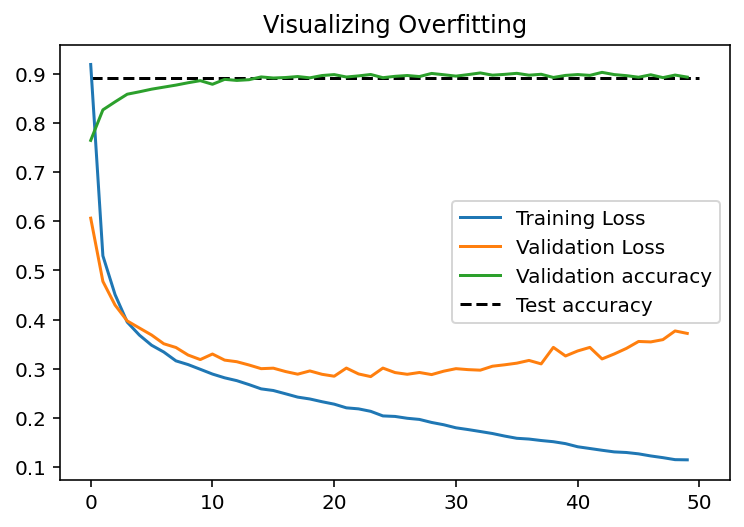

In [0]:
# plotting the results
plt.plot(model_overfitting.train_loss, label='Training Loss')
plt.plot(model_overfitting.vali_loss, label='Validation Loss')
plt.plot(model_overfitting.accuracy, label='Validation accuracy')
plt.hlines(model_overfitting.test_accuracy/len(testloader),0,50, label='Test accuracy', linestyles='dashed',)


plt.title('Visualizing Overfitting')
plt.legend()
plt.show()
plt.close()

Net we move on to using dropout to regularize the network. Interestingly, two two resources https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html and https://towardsdatascience.com/dropout-on-convolutional-layers-is-weird-5c6ab14f19b2 state that dropout should only be used on fully connected layers. So I follow this idea.

In [0]:
#   model with dropout
model_dropout=Lenet5_ext(
    28,
    10,
    lr=0.001,
    epochs=50,
    drop_proba=0.2,
    use_cuda=True,
    use_drop_out=True
    )
model_dropout.train_loop(trainloader, valiloader)
model_dropout.testing(testloader)

Using Dropout
Using GPU
____________________Running Epoch 1____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.9471110273548897
This epoch took 6 seconds to train

Validation loss: 0.5630766197722009
Validation Accuracy : 0.7811669111251831


____________________Running Epoch 2____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.5580124114739134
This epoch took 6 seconds to train

Validation loss: 0.4744257051894005
Validation Accuracy : 0.8252873420715332


____________________Running Epoch 3____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.4834502986

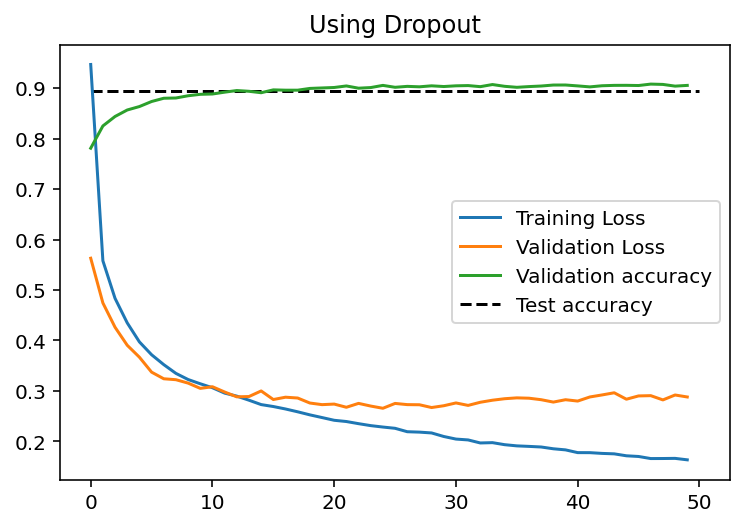

In [0]:
plt.plot(model_dropout.train_loss, label='Training Loss')
plt.plot(model_dropout.vali_loss, label='Validation Loss')
plt.plot(model_dropout.accuracy, label='Validation accuracy')
plt.hlines(model_dropout.test_accuracy/len(testloader),0,50, label='Test accuracy', linestyles='dashed',)


plt.title('Using Dropout')
plt.legend()
plt.show()
plt.close()

Firrstly we notice that the validation loss stays fairly constant even though the train loss continues to fall. Howoever the influence on the test set accuracy is neglible. This could be coincidence or have to do with the fact that while the validation loss grows in the model with overfitting it does not mean that the predictions changes.

Finally, we move on to the model with __early stopping__


In [0]:
model_earlyStopping=Lenet5_ext(28, 10, lr=0.001, epochs=50, drop_proba=0.0,use_cuda=True)
model_earlyStopping.train_loop(trainloader, valiloader,early_stopping=True)
model_earlyStopping.testing(testloader)

Not using Dropout
Using GPU
____________________Running Epoch 1____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.938892089623086
This epoch took 6 seconds to train

Validation loss: 0.6108329422930454
Validation Accuracy : 0.7578243613243103


____________________Running Epoch 2____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.548949715304882
This epoch took 6 seconds to train

Validation loss: 0.513516885169009
Validation Accuracy : 0.8043550252914429


____________________Running Epoch 3____________________________________________________________________________________________________________________________________________________________________________________

Training loss: 0.469603475

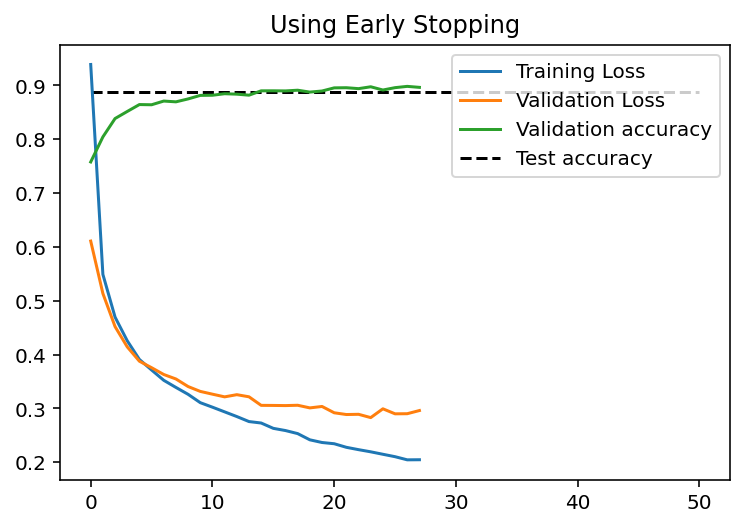

In [0]:
plt.plot(model_earlyStopping.train_loss, label='Training Loss')
plt.plot(model_earlyStopping.vali_loss, label='Validation Loss')
plt.plot(model_earlyStopping.accuracy, label='Validation accuracy')
plt.hlines(model_earlyStopping.test_accuracy/len(testloader),0,50, label='Test accuracy', linestyles='dashed',)


plt.title('Using Early Stopping')
plt.legend()
plt.show()
plt.close()